In [5]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import mplstylize

from scipy.interpolate import PchipInterpolator
from acoustic_resonators.theory.config import paths as theory_paths

%config InlineBackend.figure_format = 'retina'

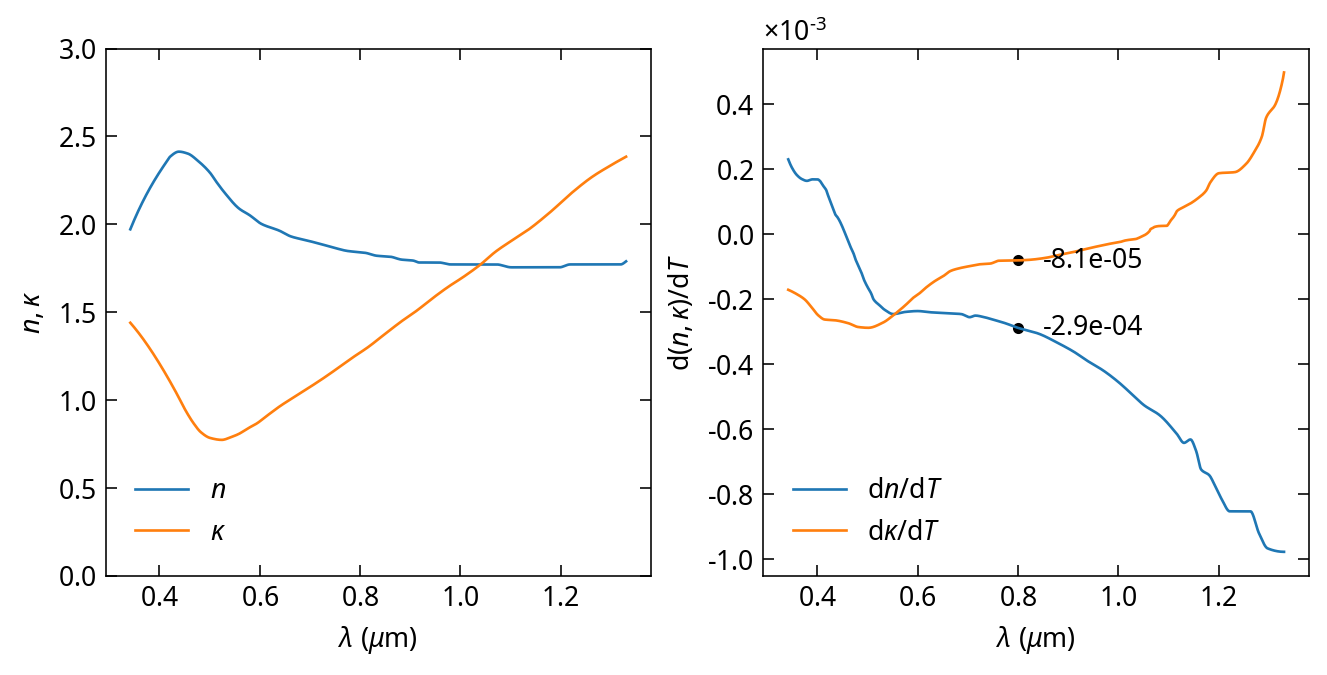

In [6]:
coeff_imag = (
    pl.read_csv(
        theory_paths.root / "literature_data/temperature_coeff_imag.csv",
        comment_prefix="#",
    )
    .with_columns(pl.col("dk/dT") * 1e-4)
    .unique("wavelength")
    .sort("wavelength")
)
coeff_real = (
    pl.read_csv(
        theory_paths.root / "literature_data/temperature_coeff_real.csv",
        comment_prefix="#",
    )
    .with_columns(pl.col("dn/dT") * 1e-4)
    .unique("wavelength")
    .sort("wavelength")
)
index_imag = (
    pl.read_csv(
        theory_paths.root / "literature_data/index_imag.csv",
        comment_prefix="#",
    )
    .unique("wavelength")
    .sort("wavelength")
)
index_real = (
    pl.read_csv(
        theory_paths.root / "literature_data/index_real.csv",
        comment_prefix="#",
    )
    .unique("wavelength")
    .sort("wavelength")
)

min_lda = max(coeff_imag["wavelength"].min(), coeff_real["wavelength"].min())
max_lda = min(coeff_imag["wavelength"].max(), coeff_real["wavelength"].max())
lda = np.linspace(min_lda, max_lda, 1_000)

dκ_dT = PchipInterpolator(coeff_imag["wavelength"], coeff_imag["dk/dT"])
dn_dT = PchipInterpolator(coeff_real["wavelength"], coeff_real["dn/dT"])
n = PchipInterpolator(index_real["wavelength"], index_real["n"])
κ = PchipInterpolator(index_imag["wavelength"], index_imag["k"])

fig, ax = plt.subplots(1, 2, figsize=(6.8, 3.4))

ax[1].plot(lda, dn_dT(lda), label=r"$\mathrm{d}n/\mathrm{d}T$")
ax[1].plot(lda, dκ_dT(lda), label=r"$\mathrm{d}\kappa/\mathrm{d}T$")
ax[1].scatter(0.8, dκ_dT(0.8), c="black", s=10)
ax[1].annotate(
    f"{dκ_dT(0.8):.1e}",
    (0.8, dκ_dT(0.8)),
    xytext=(0.8 + 0.05, dκ_dT(0.8)),
    ha="left",
    va="center",
    zorder=np.inf,
)
ax[1].scatter(0.8, dn_dT(0.8), c="black", s=10)
ax[1].annotate(
    f"{dn_dT(0.8):.1e}",
    (0.8, dn_dT(0.8)),
    xytext=(0.8 + 0.05, dn_dT(0.8)),
    ha="left",
    va="center",
    zorder=np.inf,
)
ax[1].set(xlabel=r"$\lambda$ ($\mu$m)", ylabel=r"$\mathrm{d}(n,\kappa)/\mathrm{d}T$")
ax[1].legend()

ax[0].plot(lda, n(lda), label=r"$n$")
ax[0].plot(lda, κ(lda), label=r"$\kappa$")
ax[0].set(xlabel=r"$\lambda$ ($\mu$m)", ylim=(0, 3), ylabel=r"$n,\kappa$")
ax[0].legend()

plt.show()

In [7]:
lda0 = 0.8
k0 = 2 * np.pi / lda0
ns = 1.4305  # CaF2

dR_R_T = (
    8
    * k0
    / ((2 * κ(lda0) * n(lda0) * k0 + ns) ** 2 - 1)
    * (n(lda0) * dκ_dT(lda0) + κ(lda0) * dn_dT(lda0))
)
print(f"dR/R = {dR_R_T:.2e}/K * dT")

dR/R = -2.23e-05/K * dT


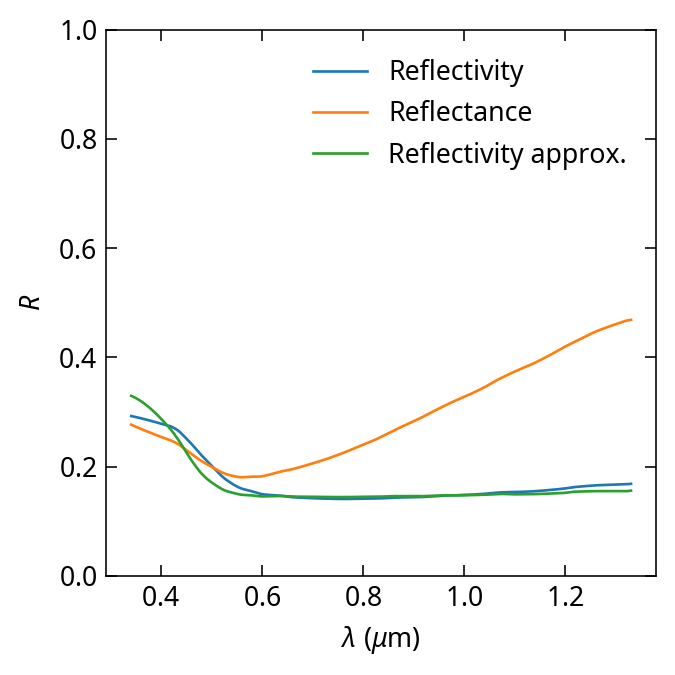

In [8]:
def reflectivity(lda, d, ns):
    m = n(lda) + 1j * κ(lda)
    r12 = (1 - m) / (1 + m)
    r23 = (m - ns) / (m + ns)
    p2 = np.exp(1j * 2 * np.pi * m * d / lda)
    return np.abs((r12 + r23 * p2**2) / (1 + r12 * r23 * p2**2)) ** 2


def reflectivity_approx(lda, d, ns):
    k = 2 * np.pi / lda
    x = 2 * k * d * κ(lda) * n(lda)
    return np.abs((1 - ns - x) / (1 + ns + x)) ** 2


def reflectance(lda):
    m = n(lda) + 1j * κ(lda)
    return np.abs((1 - m) / (1 + m)) ** 2


def absorptivity(lda, d, ns):
    k = 2 * np.pi / lda
    x = 2 * k * d * κ * n
    return 2 * x / (1 + ns + x) ** 2


ns = 2.34  # SrTiO3 m
ns = 1.4305  # CaF2
d = 21.7e-3  # Film thickness, [um]
k0 = 2 * np.pi / lda

R_full = reflectivity(lda, d, ns)
R_aprx = reflectivity_approx(lda, d, ns)
R_bulk = reflectance(lda)

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
ax.plot(lda, R_full, label="Reflectivity")
ax.plot(lda, R_bulk, label="Reflectance")
ax.plot(lda, R_aprx, label="Reflectivity approx.")
ax.set(xlabel=r"$\lambda$ ($\mu$m)", ylabel=r"$R$", ylim=(0, 1))
ax.legend()
plt.show()

In [9]:
# ns = 2.34  # SrTiO3 index
ns = 1.4305  # CaF2 index
d = 21.7e-3  # Film thickness, [um]
lda0 = 0.8  # [um]

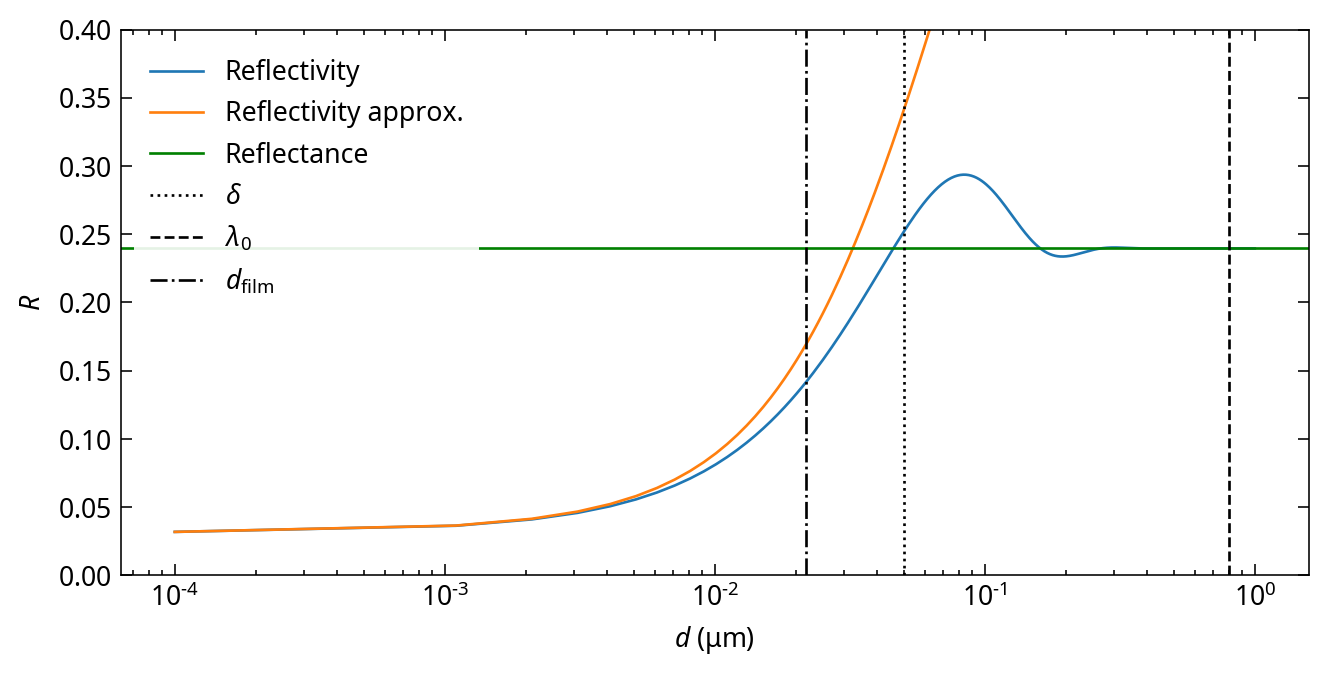

In [10]:
ns = 1.4305  # CaF2 index
d = np.linspace(1e-4, 1, 1_000)  # Film thickness, [um]
d_film = 21.7e-3 # Film thickness, [um]
lda0 = 0.8  # [um]


def reflectivity(m, d):
    r12 = (1 - m) / (1 + m)
    r23 = (m - ns) / (m + ns)
    p2 = np.exp(1j * 2 * np.pi * m * d / lda0)
    return np.abs((r12 + r23 * p2**2) / (1 + r12 * r23 * p2**2)) ** 2


def reflectivity_approx(m, d):
    alpha = (4 * np.pi / lda0) * np.imag(m)
    return np.abs((1 - ns - alpha * d * m) / (1 + ns + alpha * d * m)) ** 2


def reflectance(m):
    return np.abs((1 - m) / (1 + m)) ** 2


fig, ax = plt.subplots(1, 1, figsize=(6.8, 3.4))

dT = np.linspace(0, 800, 1_000)
m_0 = n(lda0) + 1j * κ(lda0)

funcs = [reflectivity, reflectivity_approx]
labels = ["Reflectivity", "Reflectivity approx."]
for i, func in enumerate(funcs):
    ax.plot(d, func(m_0, d), label=labels[i])
    ax.set(xlabel=r"$d$ (μm)", ylabel=r"$R$")

ax.axhline(y=reflectance(m_0), label="Reflectance", color="green")
ax.set(xscale="log", ylim=(0, 0.4))

pen_depth = lda0 / (4 * np.pi * κ(lda0))
ax.axvline(x=pen_depth, color="black", linestyle=":", label=r"$\delta$")
ax.axvline(x=lda0, color="black", linestyle="--", label=r"$\lambda_0$")
ax.axvline(x=21.7e-3, color="black", linestyle="-.", label=r"$d_\mathrm{film}$")
ax.legend()

plt.show()

In [11]:
from sympy import symbols, Derivative

n = symbols("n", real=True)
κ = symbols("κ", real=True)
ns = symbols("n_s", real=True)
k0 = symbols("k_0", real=True)
d = symbols("d", real=True)

R = (1 - ns - 2 * d * k0 * κ * n) ** 2 / (1 + ns + 2 * d * k0 * κ * n) ** 2

dR = Derivative(R, n).simplify() * symbols(r"{\Delta}n") + Derivative(
    R, κ
).simplify() * symbols(r"{\Delta}\kappa")
dR = dR.simplify()

(dR / R).simplify()

8*d*k_0*(n*{\Delta}\kappa + {\Delta}n*κ)/((2*d*k_0*n*κ + n_s - 1)*(2*d*k_0*n*κ + n_s + 1))